In [33]:
import pandas as pd
import numpy as np
import plotly.express as px
from sklearn.model_selection import train_test_split
import lightgbm
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GroupKFold
from sklearn.metrics import f1_score, roc_auc_score, classification_report, roc_curve, auc
from catboost import CatBoostClassifier
import time
import os
from sklearn.linear_model import LogisticRegression

In [2]:
from IPython.core.display import display, HTML, clear_output
display(HTML("<style>.container { width:85% !important; }</style>"))
display(HTML("<style>.prompt { min-width:10ex !important; }</style>"))
pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_columns', 1000)
pd.set_option('display.float_format', lambda x: '%.6f' % x) 

/tmp/ipykernel_55203/437858164.py:1: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML, clear_output
/tmp/ipykernel_55203/437858164.py:1: DeprecationWarning: Importing clear_output from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML, clear_output


In [3]:
df_with_feats = pd.read_parquet("../data/train_with_feats_v4.parquet")

In [4]:
df_train, df_val = train_test_split(df_with_feats, test_size=0.2, random_state=42, stratify=df_with_feats.buy_post)

In [5]:
information_value = pd.read_csv('../data/feature_information_value.csv', sep=';')

### Feature selection

IV < 0,02 — отсутствует; 

0,02 ≤ IV <0,1 — низкая; 

0,1 ≤ IV < 0,3 — средняя; 


IV ≥ 0,3 — высокая. 


In [6]:
best_iv_feats = information_value[information_value["IV"] >= 0.02].feature.values
len(best_iv_feats)

42

In [7]:
information_value[information_value["IV"] >= 0.02].sort_values(by="IV", ascending=False)

,feature,IV
62,receipt_count,0.430457
30,weekends_std,0.243150
69,strange_std,0.237534
47,dom_std,0.161640
1,revenue_sum_count_14d,0.155249
65,revenue_sum_count_28d,0.155249
3,revenue_sum_count_7d,0.155249
35,was_promo_std,0.120205
46,fun_sum,0.105191
88,dow_std,0.097692


In [8]:
bad_feats = [
#     "items_count_sum_28d",
    "items_count_sum_14d", 
    "items_count_sum_7d", 
#     "revenue_sum_sum_28d",
    "minutes_var",
    "revenue_sum_count_14d",
    "minutes_sem",
    "revenue_sum_count_7d",
    "revenue_sum_count_28d",
    "revenue_sum_sum_14d",
    "revenue_sum_sum_7d",
    "dom_mean",
    "dow_mean",
    "count_delta_max",
    "count_delta_min",
#     "receipt_count", # or "revenue_sum_count_28d"
#     "sum_delta_min",
    "diff",
#     "receipt_count",
]

In [9]:
filtered_feats = [feat for feat in best_iv_feats if feat not in bad_feats]

In [11]:
len(best_iv_feats), len(filtered_feats)

(42, 28)

In [12]:
df_with_feats[filtered_feats].corr()

,ratio,was_rec_std,sum_delta_min,abs_count_delta_mean,count_delta_mean,weekends_std,was_promo_std,items_count_sum_28d,is_burger_std,was_promo_mean,strange_mean,fun_sum,dom_std,weekends_mean,sqm_place_sem,first_half_min,receipt_count,minutes_std,strange_std,dom_median,revenue_sum_sum_28d,sum_delta_mean,dow_std,count_delta_std,cosine_similarity,abs_sum_delta_mean,sum_delta_max,fun_std
ratio,1.000000,0.001247,0.050044,0.064106,0.105682,-0.015628,-0.002875,-0.030231,-0.001606,0.023254,0.001045,-0.025240,-0.013136,0.000626,0.010636,-0.075763,-0.035425,-0.007376,-0.017780,-0.007583,-0.026670,0.137438,-0.011372,0.025034,0.010650,0.097386,0.065100,0.006646
was_rec_std,0.001247,1.000000,-0.132694,0.143807,-0.042153,0.013532,0.012010,0.173579,0.056725,0.281195,0.000510,0.227822,0.018437,0.004227,0.051009,0.039630,0.042288,0.035032,0.018448,-0.006032,0.097527,-0.025556,0.019163,0.245877,-0.318352,0.064522,0.116443,0.399342
sum_delta_min,0.050044,-0.132694,1.000000,-0.097017,0.290910,0.005617,-0.114975,-0.254872,-0.059257,-0.009531,0.008860,-0.192406,0.000523,-0.042335,0.006747,-0.249984,-0.154225,-0.031075,-0.003848,-0.000422,-0.421090,0.457197,-0.009850,-0.432341,0.262895,-0.260869,-0.569947,-0.237493
abs_count_delta_mean,0.064106,0.143807,-0.097017,1.000000,-0.209659,-0.109304,-0.002822,-0.022484,0.053714,0.111134,-0.014290,-0.026710,-0.083963,0.042686,0.076564,0.333880,-0.259641,-0.044673,-0.102125,-0.002662,-0.048286,-0.156260,-0.076435,0.315811,-0.172100,0.592858,-0.026914,0.362852
count_delta_mean,0.105682,-0.042153,0.290910,-0.209659,1.000000,0.061222,-0.008599,0.057342,-0.010551,-0.019006,0.010847,0.002466,0.073296,-0.014261,0.011270,-0.278280,0.039023,0.046612,0.074599,-0.020832,0.054557,0.674339,0.062019,-0.064221,0.031289,-0.162498,0.269005,-0.077888
weekends_std,-0.015628,0.013532,0.005617,-0.109304,0.061222,1.000000,-0.009638,0.096426,-0.015241,0.030400,0.017621,0.085393,0.123407,-0.402731,0.021131,-0.094134,0.145124,0.108026,0.124454,0.000315,0.068876,0.058942,0.721109,-0.039106,-0.029263,-0.115870,0.040510,-0.009286
was_promo_std,-0.002875,0.012010,-0.114975,-0.002822,-0.008599,-0.009638,1.000000,-0.087444,0.107053,-0.348331,-0.008412,-0.111039,-0.011026,0.016672,0.002841,-0.053799,0.059421,0.023944,-0.012630,-0.001743,0.040217,-0.017715,-0.004325,0.033796,-0.092363,0.038319,0.104105,-0.018946
items_count_sum_28d,-0.030231,0.173579,-0.254872,-0.022484,0.057342,0.096426,-0.087444,1.000000,0.016220,0.276646,0.000933,0.683844,0.083947,-0.012977,-0.072516,-0.038557,0.592967,0.055210,0.104242,0.012931,0.763619,0.046471,0.083464,0.273168,-0.311486,-0.093643,0.304499,0.302531
is_burger_std,-0.001606,0.056725,-0.059257,0.053714,-0.010551,-0.015241,0.107053,0.016220,1.000000,0.030969,-0.009361,-0.047368,-0.004497,0.017385,0.003649,0.055195,-0.038086,-0.005660,-0.010993,0.001582,0.039634,-0.013664,-0.003565,0.057498,-0.374932,0.059426,0.050917,0.018397
was_promo_mean,0.023254,0.281195,-0.009531,0.111134,-0.019006,0.030400,-0.348331,0.276646,0.030969,1.000000,0.008276,0.308759,0.035578,-0.011468,0.036319,0.036780,0.018362,0.007568,0.035040,-0.003511,0.049035,-0.004568,0.030789,0.188375,-0.272385,-0.017564,0.004952,0.300159


In [29]:
import plotly.io as pio

pio.renderers
pio.renderers.default = "png"

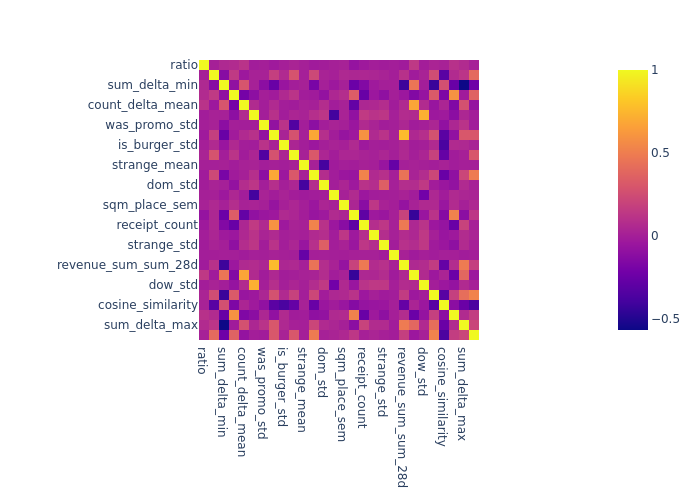

In [30]:
fig = px.imshow(df_with_feats[filtered_feats].corr())
fig.show()

### Modeling

In [16]:
df_train["buy_post"].value_counts()

buy_post
1    287276
0    112724
Name: count, dtype: int64

In [17]:
scale_pos_weight = 112724 / 287276

In [18]:
params = {
    'boosting_type': 'gbdt',
    'objective': 'binary',
    'metric': "binary",
    'num_leaves': 50,
    'max_depth': 20,
    'learning_rate': 0.15,
    'colsample_bytree': 0.8,
    'subsample': 0.8,
    'subsample_freq': 1,
    'n_jobs': 4,
    'n_estimators': 300,
    'scale_pos_weight': scale_pos_weight,
    'class_weight': None,
    'colsample_bytree': 0.8,
    'importance_type': 'gain',
    'min_child_samples': 50,
    'min_child_weight': 0.001,
    'min_split_gain': 0.0,
    'random_state': None,
    'reg_alpha': 0.0,
    'reg_lambda': 0.0,
    'subsample_for_bin': 200000,
}

In [19]:
current_feats = filtered_feats
len(current_feats)

28

In [21]:
lgbm_model = lightgbm.LGBMModel(**params)

In [22]:
lgbm_model.fit(df_train[current_feats], df_train["buy_post"])

[LightGBM] [Info] Number of positive: 287276, number of negative: 112724
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.032435 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5708
[LightGBM] [Info] Number of data points in the train set: 400000, number of used features: 28
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.718190 -> initscore=0.935501
[LightGBM] [Info] Start training from score 0.935501


LGBMModel(colsample_bytree=0.8, importance_type='gain', learning_rate=0.15,
          max_depth=20, metric='binary', min_child_samples=50, n_estimators=300,
          n_jobs=4, num_leaves=50, objective='binary',
          scale_pos_weight=0.3923892006293599, subsample=0.8, subsample_freq=1)

In [23]:
y_pred_lgbm = lgbm_model.predict(df_val[current_feats])

In [24]:
def with_cutoff(y_pred, cut_off):
    return [int(x > cut_off) for x in y_pred]

In [25]:
current_cut_off = 0.4

print(classification_report(df_val["buy_post"], with_cutoff(y_pred_lgbm, current_cut_off)))

              precision    recall  f1-score   support

           0       0.47      0.46      0.47     28181
           1       0.79      0.80      0.79     71819

    accuracy                           0.70    100000
   macro avg       0.63      0.63      0.63    100000
weighted avg       0.70      0.70      0.70    100000



In [26]:
f1_score(df_val["buy_post"], with_cutoff(y_pred_lgbm, current_cut_off))

0.7939644108363106

In [27]:
roc_auc_score(df_val["buy_post"], y_pred_lgbm)

0.7143831381911884

In [31]:
fpr, tpr, thresholds = roc_curve(df_val["buy_post"], y_pred_lgbm)

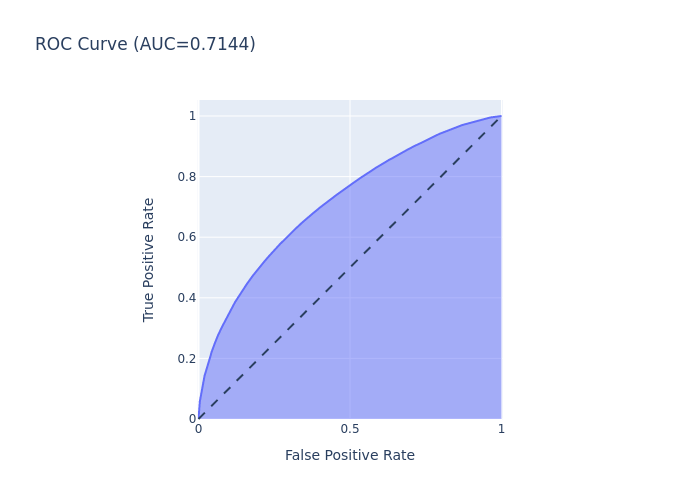

In [34]:
fig = px.area(
    x=fpr, y=tpr,
    title=f'ROC Curve (AUC={auc(fpr, tpr):.4f})',
    labels=dict(x='False Positive Rate', y='True Positive Rate'),
    width=700, height=500
)
fig.add_shape(
    type='line', line=dict(dash='dash'),
    x0=0, x1=1, y0=0, y1=1
)

fig.update_yaxes(scaleanchor="x", scaleratio=1)
fig.update_xaxes(constrain='domain')
fig.show()

### Test data

In [35]:
df_test = pd.read_parquet("../data/test_with_feats_v4.parquet")

In [36]:
y_test_pred = lgbm_model.predict(df_test[current_feats])

In [37]:
df_test["buy_post"] = with_cutoff(y_test_pred, current_cut_off)

In [38]:
df_test[["customer_id", "buy_post"]].describe()

,customer_id,buy_post
count,112334.000000,112334.000000
mean,20748611.321951,0.666753
std,11582578.505840,0.471376
min,52341.000000,0.000000
25%,11041231.250000,0.000000
50%,22155898.000000,1.000000
75%,28861910.500000,1.000000
max,46668221.000000,1.000000


In [39]:
df_test[["customer_id", "buy_post"]].to_csv("test_pred_submission.csv", sep=';', index=False)